In [1]:
# Mounting to google drive
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# importing the libraries
import numpy as np
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, Sequential, regularizers, metrics
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
# from tensorflow.keras.models import Sequential, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support

In [3]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/gdrive/MyDrive/Dataset/train'
valid_path = '/content/gdrive/MyDrive/Dataset/test'

In [4]:
# Import the InceptionV3 library as shown below and add preprocessing layer to the front of InceptionV3
# Here we will be using imagenet weights

inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

87910968/87910968 [==============================] - 5s 0us/step


In [5]:
# don't train existing weights
for layer in inception.layers:
    layer.trainable = False

In [6]:
# useful for getting number of output classes
folders = glob('/content/gdrive/MyDrive/Dataset/train')

In [7]:
# our layers - you can add more if you want
x = Flatten()(inception.output) # layers added

In [8]:
x=layers.Dense(1024, activation='relu')(x)

In [9]:
# Add a dropout rate of 0.2
# x=layers.Dropout(0.2)(x)

In [10]:
prediction = Dense(2, activation='sigmoid')(x)

# create a model object
inception_model = Model(inputs=inception.input, outputs=prediction)

In [11]:
# view the structure of the model
inception_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [12]:
# Using the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [13]:
#  provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/gdrive/MyDrive/Dataset/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 2637 images belonging to 2 classes.


In [14]:
# Values from directory for test datagen
test_set = test_datagen.flow_from_directory('/content/gdrive/MyDrive/Dataset/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 660 images belonging to 2 classes.


In [15]:
# from tensorflow_addons.metrics import F1Score, MatthewsCorrelationCoefficient

METRICS=['accuracy',
metrics.Precision(name='precision'),
metrics.Recall(name='recall'),
# F1Score(num_classes=2,name='f1'),
# MatthewsCorrelationCoefficient(num_classes=2,name='mc'),
tf.keras.metrics.TruePositives(name='tp'),
tf.keras.metrics.TrueNegatives(name='tn'),
tf.keras.metrics.FalseNegatives(name='fn'),
tf.keras.metrics.FalsePositives(name='fp')]

In [16]:
# tell the model what cost and optimization method to use
inception_model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics= METRICS
)

In [ ]:
# fit the model

history = inception_model.fit(
    training_set,
    batch_size=32,
    steps_per_epoch = len(training_set),
    validation_data = test_set,
    validation_steps = len(test_set),
    verbose =1,
    epochs = 15
)

Epoch 1/15
83/83 [==============================] - ETA: 0s - loss: 8.2597 - accuracy: 0.7095 - precision: 0.7349 - recall: 0.5529 - tp: 1458.0000 - tn: 2111.0000 - fn: 1179.0000 - fp: 526.0000 

In [ ]:
#Testing accuracy
scores = inception_model.evaluate(test_set)

21/21 [==============================] - 3s 145ms/step - loss: 0.3786 - accuracy: 0.8439 - precision: 0.8961 - recall: 0.4182 - tp: 276.0000 - tn: 628.0000 - fn: 384.0000 - fp: 32.0000


In [ ]:
scores
print("[INFO] Accuracy: {:.2f}%".format(scores[1] * 100))
print("[INFO] Loss: ",scores[0])

[INFO] Accuracy: 84.39%
[INFO] Loss:  0.3785911798477173


In [ ]:
# inception_model.save('/content/gdrive/MyDrive/Colab Notebooks/i_model.h5')

In [ ]:
# Parameters in history
history.params

{'verbose': 1, 'epochs': 15, 'steps': 83}

In [ ]:
# Extracting keys from history
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'tp', 'tn', 'fn', 'fp', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_tp', 'val_tn', 'val_fn', 'val_fp'])

In [ ]:
# Getting accuracy and loss value
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
def plot_training_curves(history):
  loss = np.array(history.history['loss'])
  val_loss = np.array(history.history['val_loss'])
  accuracy = np.array(history.history['accuracy'])
  val_accuracy = np.array(history.history['val_accuracy'])
  epochs = range(len(history.history['loss']))
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
  # Plot loss
  ax1.plot(epochs, loss, label='training_loss', marker='o')
  ax1.plot(epochs, val_loss, label='val_loss', marker='o')
  ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
  ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)
  ax1.set_title('Loss (Lower Means Better)', fontsize=16)
  ax1.set_xlabel('Epochs', fontsize=12)
  ax1.legend()
  # Plot accuracy
  ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
  ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')
  ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
  ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)
  ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
  ax2.set_xlabel('Epochs', fontsize=12)
  ax2.legend();


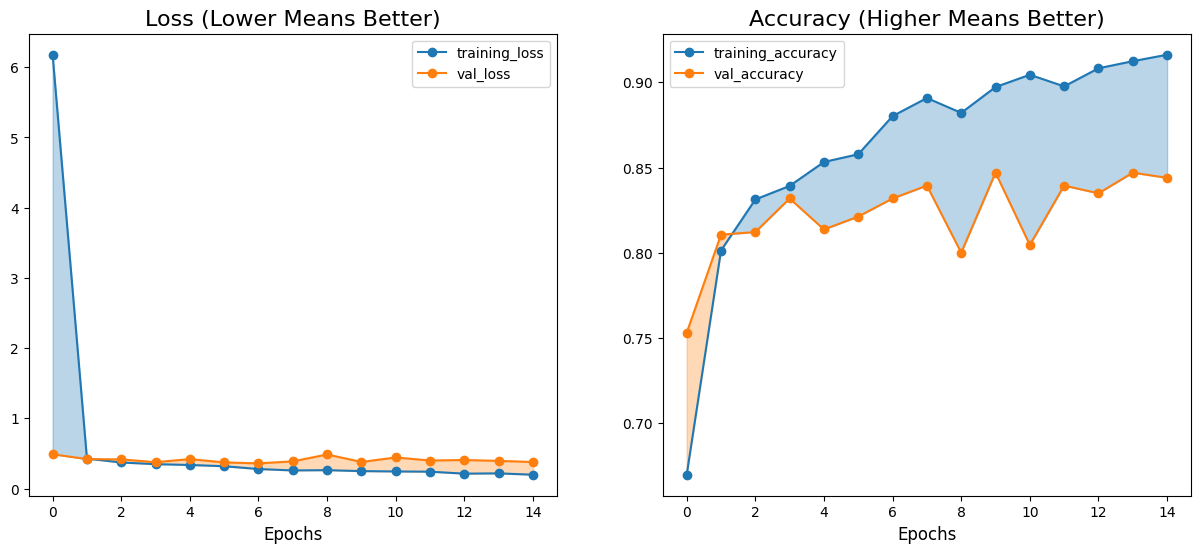

In [ ]:
plot_training_curves(history)


In [ ]:
# !pip install scikit-plot

In [ ]:
# Printing class names
class_names = list(training_set.class_indices.keys())
class_names

['benign', 'malignant']

first image to predict
actual label: malignant
1/1 [==============================] - 1s 1s/step
predicted label: malignant


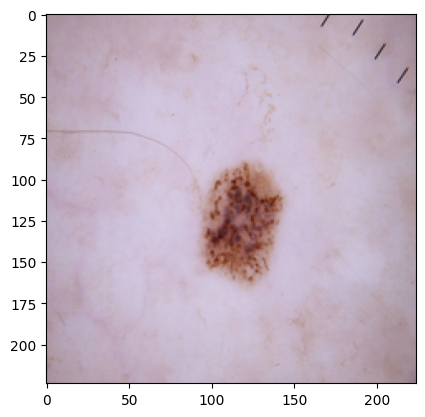

In [ ]:
### Run Prediction on a sample image

import numpy as np


for images_batch, labels_batch in test_set:
    vector = np.vectorize(np.int_) # Converting to vector 
    first_image = images_batch[0]
    # print(images_batch)
    # print(labels_batch)
    first_label = vector(labels_batch[0][1])
    # first_label = int(labels_batch[0])
    # print(first_label)
    # print(type(first_label))
    # print(class_names[first_label])
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",np.array(class_names)[first_label])
    
    batch_prediction = inception_model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

    break

In [ ]:
# Function for prediction in batches
import tensorflow as tf
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i])
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100* (np.max(predictions[0])), 2)
  return predicted_class, confidence, predictions

1/1 [==============================] - 0s 167ms/step


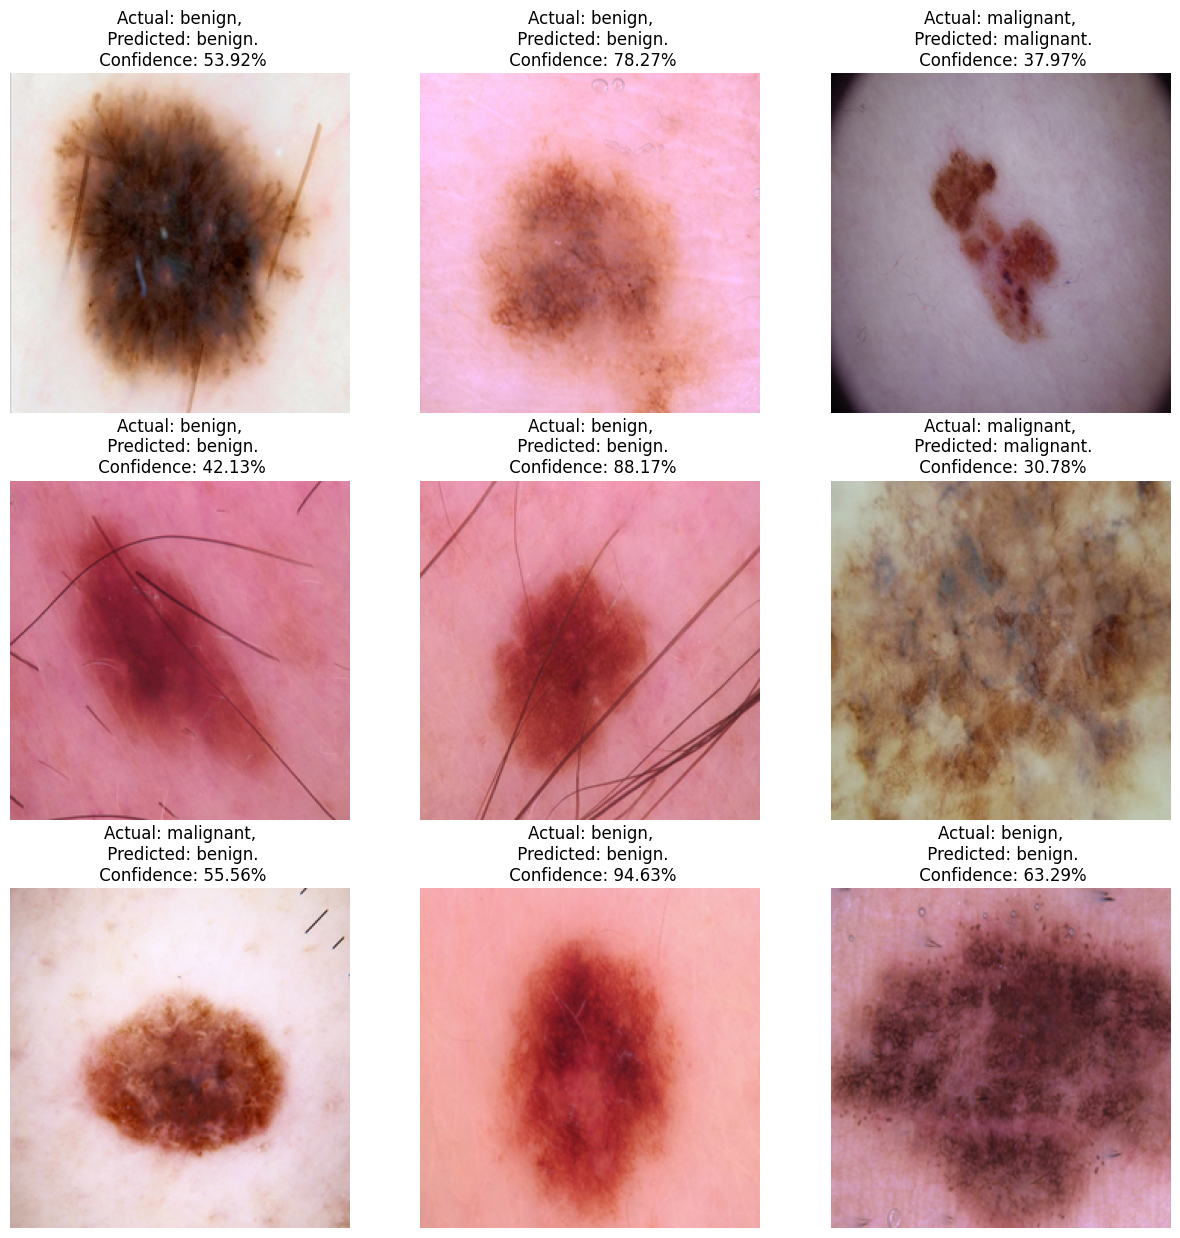

In [ ]:
# Plotting of Images with actual, predicted and confidence value
plt.figure(figsize=(15, 15))
for images, labels in test_set:
    vector = np.vectorize(np.int_)

    for i in range(9):
        
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        
        predicted_class, confidence, predictions = predict(inception_model, images[i])
        actual_class = np.array(class_names)[vector(labels[i][1])] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
    break

In [ ]:
model_predictions=tf.argmax(predictions,axis=1)
model_predictions

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>

In [ ]:
# PLotting Cofusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
y_predicted = inception_model.predict(test_set)

21/21 [==============================] - 3s 139ms/step


In [ ]:
y_predicted

array([[0.96373624, 0.00870963],
       [0.4931273 , 0.06980137],
       [0.07626365, 0.37579975],
       ...,
       [0.40413105, 0.26054388],
       [0.0883166 , 0.10524771],
       [0.3436044 , 0.21067879]], dtype=float32)

In [ ]:
inception_model.save('/content/gdrive/MyDrive/Colab Notebooks/model_inception.h5')

In [ ]:
y_actual=test_set.labels
# y_actual = np.array(y_actual)
print(y_actual)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [ ]:
model_version = 2
inception_model.save(f"/content/gdrive/MyDrive/models/{model_version}")
# # import os
# # model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
# # inception_model.save(f"../models/{model_version}")

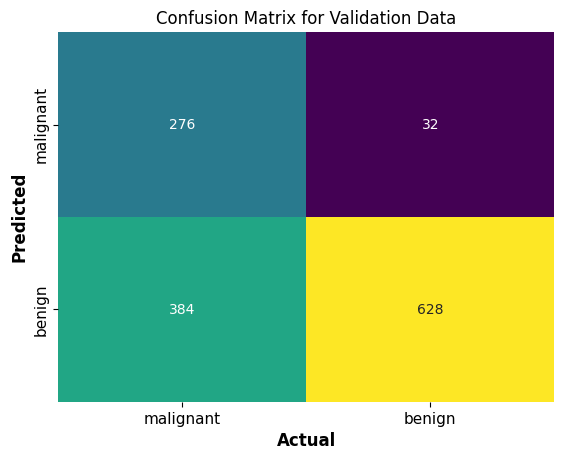

In [ ]:
import seaborn as sns
cm_data = [[history.history['val_tp'][-1], history.history['val_fp'][-1]], [history.history['val_fn'][-1], history.history['val_tn'][-1]]]
sns.heatmap(cm_data, annot=True, cmap = 'viridis',cbar = False,fmt = 'g')
plt.xticks([0.5,1.5],['malignant','benign'],fontsize=11)
plt.yticks([0.5,1.5],['malignant','benign'],fontsize=11)
plt.xlabel("Actual",fontsize=12, fontweight="bold")
plt.ylabel("Predicted",fontsize=12, fontweight="bold")
plt.title('Confusion Matrix for Validation Data')
plt.show()

In [ ]:
# print(len(test_set))
Y_pred = inception_model.predict(test_set)
# print(Y_pred)
y_pred = np.argmax(Y_pred,axis=1)
print(y_pred)

21/21 [==============================] - 3s 147ms/step
[1 1 0 0 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0
 0 1 0 1 0 0 1 1 1 1 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 1 0 1 0 1 0 1 1 1 1 1 0
 1 0 1 0 0 1 1 1 0 0 0 0 1 0 1 1 0 1 0 1 0 1 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0
 1 0 0 1 1 0 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1 1 0 1 0 1 0 1 0
 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0
 1 0 1 1 0 1 1 0 1 0 0 0 1 0 1 0 0 1 0 0 0 1 1 0 0 0 0 1 1 0 0 1 1 0 0 1 1
 0 0 0 1 1 1 0 1 0 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0 0 1 1 0 0 1 1 1 1 1 1 0 0
 1 0 1 1 0 1 0 0 1 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 1 1 0 1 1 0 0 0 0 0 0 1 0
 1 1 0 0 0 0 1 1 1 0 0 0 0 1 0 1 1 1 1 1 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 1 1
 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 1 1 1 0 1 1 0 0 1 1 1 1 1
 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 1 0 0 0 1 1 1
 1 1 0 0 1 1 1 0 0 0 1 0 0 0 1 0 1 0 1 1 0 0 1 0 1 0 0 1 0 0 0 1 1 1 1 0 0
 0 1 1 1 1 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 0 0 

In [ ]:
# %% [code]
TP = history.history['val_tp'][-1]
print("TP =", TP)
FP = history.history['val_fp'][-1]
print("FP =", FP)
TN = history.history['val_tn'][-1]
print("TN =", TN)
FN = history.history['val_fn'][-1]
print("FN =", FN)
# %% [code]
FPR= (FP/(FP+TN))
TPR= (TP/(TP+FN))
# print("FPR=", FPR)
# print("TPR=", TPR)

TP = 276.0
FP = 32.0
TN = 628.0
FN = 384.0


In [ ]:
# # %% [code]
# from sklearn.metrics import roc_curve
# def plot_roc_curve (FPR, TPR, label = None):
#   plt.plot(FPR, TPR, linewidth = 2, label = label)
#   plt.plot([0,1], [0,1], 'k--') # Dashed diagonal
#   plt.xlabel("False Positive Rate")
#   plt.ylabel("True Positive Rate (Recall)")
#   plt.grid()
# plot_roc_curve(FPR,TPR)
# plt.show()